# Notebook ICD - 6

Install libreries via terminal

In [ ]:
#!pip install keras
#!pip install tensorflow
!pip install Augmentor
!pip install tensorflow-io
#!pip install IPython
!pip install textattack

## Image data augmentation

### Using Keras

In [ ]:
# Importing necessary functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

In [ ]:
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    brightness_range = (0.5, 1.5))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = 'drive/MyDrive/ICD/ICD6/images/'
# Loading a sample image
img = load_img(path+'test_image.jpg') # this is a PIL image
# Converting the input sample image to an array
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
# Reshaping the input image
x = x.reshape((1, ) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

In [ ]:
# Generating and saving 5 augmented samples using the above defined parameters.
i = 0
for batch in datagen.flow(x, batch_size = 1, save_to_dir ='drive/MyDrive/ICD/ICD6/new_images', save_prefix ='image', save_format ='jpg'):
    i += 1
    if i > 5:
        break

### Using Augmentor

In [ ]:
# Importing necessary library
import Augmentor
# Passing the path of the image directory
p = Augmentor.Pipeline(path)

Initialised with 1 image(s) found.
Output directory set to drive/MyDrive/ICD/ICD6/images/output.

In [ ]:
# Defining augmentation parameters and generating 5 samples
p.flip_left_right(0.5)
p.black_and_white(0.1)
p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.sample(5)

Processing <PIL.Image.Image image mode=RGB size=598x598 at 0x78390C04FEB0>: 100%|██████████| 5/5 [00:00<00:00, 12.92 Samples/s]


## Audio Data Preparation and Augmentation

In [ ]:
#importing necessary libraries
import tensorflow as tf
import tensorflow_io as tfio
import IPython
import numpy as np

In [ ]:
path = 'drive/MyDrive/ICD/ICD6/audios/'
#to play the audio
IPython.display.Audio(path+"test_audio.wav")

In [ ]:
#loading and reading the audio file.
audio_data = tfio.audio.AudioIOTensor(path+"test_audio.wav")
print(audio_data)
print(audio_data.shape)
print(audio_data.rate)

<AudioIOTensor: shape=[172696      1], dtype=<dtype: 'int16'>, rate=48000>
tf.Tensor([172696      1], shape=(2,), dtype=int64)
tf.Tensor(48000, shape=(), dtype=int32)


In [ ]:
#perform slicing
audio_sl = audio_data[5000:]
print('Shape After Slicing :',audio_sl.shape)

#last dimension is ignored.
audio_t = tf.squeeze(audio_sl, axis=[-1])
print('Shape After squeezing:',audio_t.shape)

Shape After Slicing : (167696, 1)
Shape After squeezing: (167696,)


In [ ]:
#to play the audio,
from IPython.display import Audio
Audio(audio_t.numpy(), rate=audio_data.rate.numpy())

tf.Tensor(
[ 0.00024415  0.00027467  0.00027467 ... -0.00018311 -0.00018311
 -0.00015259], shape=(167696,), dtype=float32)


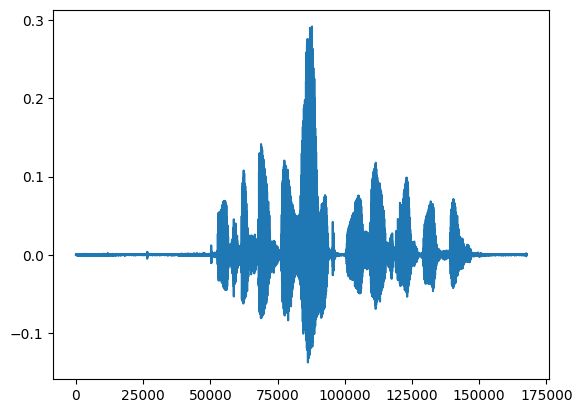

In [ ]:
# convert tensor to float datatype,.
tensor = tf.cast(audio_t, tf.float32) / 32767.0
print(tensor)

#plot the graph.
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tensor.numpy())
plt.show()

### Trimming

In [ ]:
# Trim silence from the beginning and end of the audio signal
trimed = tfio.audio.trim(tensor,
                         axis=0,
                         epsilon=0.02)
print('Trimmed :',trimed)

Trimmed : tf.Tensor([ 52781 143687], shape=(2,), dtype=int64)


START:52781,
STOP :143687
Trimmed Audio shape: (90906,)


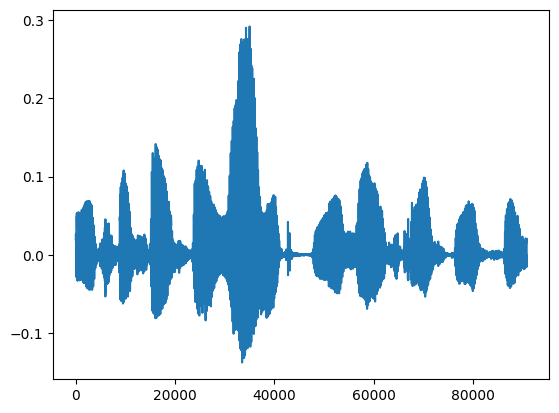

In [ ]:
#Mention the stating and ending limit
start = trimed[0]
stop = trimed[1]
print("START:{},\nSTOP :{}".format(start.numpy(),stop.numpy()))

trimmed_audio = tensor[start:stop]
print('Trimmed Audio shape:',trimmed_audio.shape)

plt.figure()
plt.plot(trimmed_audio.numpy())

In [ ]:
#to play the audio,
Audio(trimmed_audio.numpy(), rate=audio_data.rate.numpy())

### Fade in and out

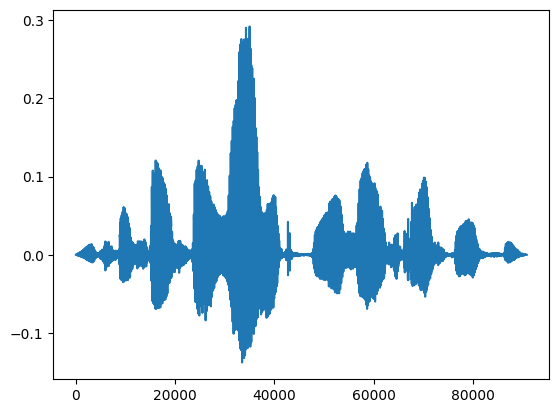

In [ ]:
#Apply a fade-in and fade_out effect with a duration
audio_fade = tfio.audio.fade(trimmed_audio, fade_in=20000, fade_out=20000, mode="logarithmic")

plt.figure()
#plotting the faded audio.
plt.plot(audio_fade.numpy())

In [ ]:
#to plat the audio
Audio(audio_fade.numpy(), rate=audio_data.rate.numpy())

### Adding noise

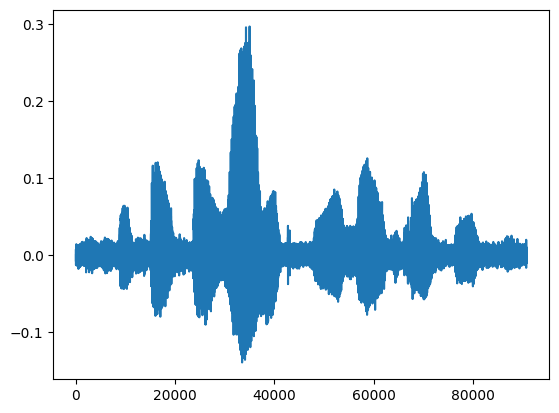

In [ ]:
# adding noise to audio
noise_factor = 0.005
noise = np.random.randn(len(audio_fade))
audio_augmented = audio_fade + noise_factor * noise

plt.figure()
plt.plot(audio_augmented.numpy())

In [ ]:
Audio(audio_augmented.numpy(), rate=audio_data.rate.numpy())

### Shifting

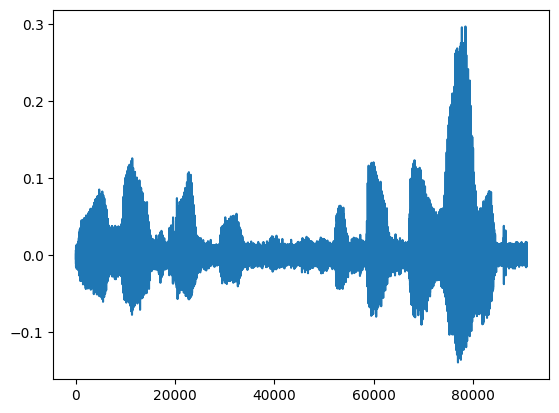

In [ ]:
shift_max = 1
shift_direction = 'right'
shift = np.random.randint(audio_data.rate.numpy() * shift_max)
if shift_direction == 'right':
    shift = -shift
audio_shifted = np.roll(audio_augmented.numpy(), shift)

# Set to silence for heading/ tailing
#if shift > 0:
    #audio_shifted[:shift] = 0
#else:
    #audio_shifted[shift:] = 0

plt.figure()
plt.plot(audio_shifted)

In [ ]:
Audio(audio_shifted, rate=audio_data.rate.numpy())

### Changing the pitch

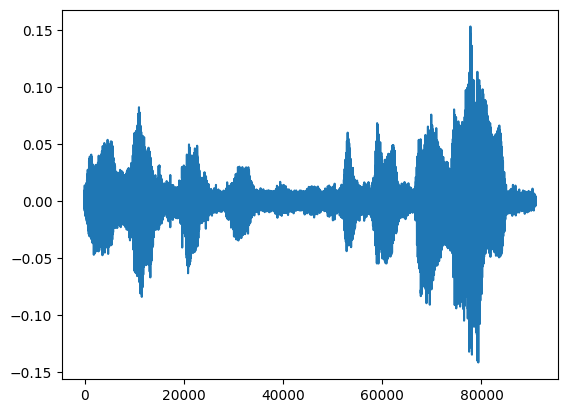

In [ ]:
import librosa
audio_pitch = librosa.effects.pitch_shift(audio_shifted, sr=audio_data.rate.numpy(), n_steps=4)
plt.figure()
plt.plot(audio_pitch)

In [ ]:
Audio(audio_pitch, rate=audio_data.rate.numpy())

### Changing the speed

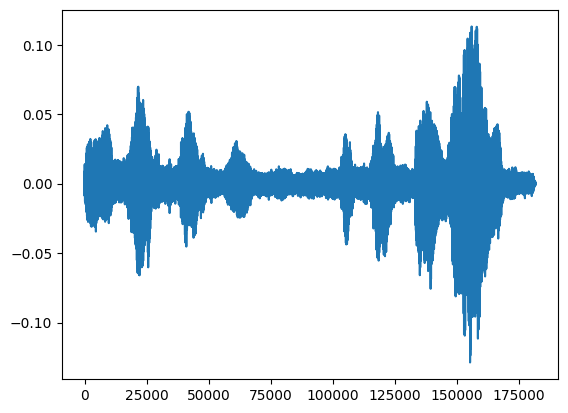

In [ ]:
audio_speed = librosa.effects.time_stretch(audio_pitch, rate=0.5)
plt.figure()
plt.plot(audio_speed)

In [ ]:
Audio(audio_speed, rate=audio_data.rate.numpy())

## Data augmentation in text

### Synonym

In [ ]:
from textattack.augmentation import WordNetAugmenter
text = "start each day with positive thoughts and make your day"
wordnet_aug = WordNetAugmenter()
wordnet_aug.augment(text)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['start each day with positive thoughts and wee your day']

### Embedding

In [ ]:
from textattack.augmentation import EmbeddingAugmenter
embed_aug = EmbeddingAugmenter()
embed_aug.augment(text)

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:12<00:00, 38.8MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpuypln584.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


['cranking each day with positive thoughts and make your day']

### Char swap

In [ ]:
from textattack.augmentation import CharSwapAugmenter
charswap_aug = CharSwapAugmenter()
charswap_aug.augment(text)

['start each dy with positive thoughts and make your day']

### Augments words by using the transformation methods, which combines:
*   Name Replacement
*   Location Replacement
*   Number Alteration
*   Contraction/Extension






In [ ]:
from textattack.augmentation import CheckListAugmenter
checklist_aug = CheckListAugmenter()
checklist_aug.augment(text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/419M [00:00<?, ?B/s]

2024-09-11 20:38:36,911 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


['start each day with positive thoughts and make your day']

### Synonym, deletion, order swaps and random synonym insertion

In [ ]:
from textattack.augmentation import EasyDataAugmenter
eda_aug = EasyDataAugmenter()
eda_aug.augment(text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['start each day with thoughts and make your day',
 'start each day with positive thoughts and make your daylight day',
 'start each day with positive thoughts make and your day',
 'start each day with positive thought and make your day']